In [41]:
from typing import Tuple
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
import os
import math
import numpy as np
import cv2
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops

from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2
from waymo_open_dataset.protos import end_to_end_driving_submission_pb2 as wod_e2ed_submission_pb2
# Replace this path with your own tfrecords.
# This tutorial is based on using data in the E2E Driving proto format directly,
# so choose the correct dataset version.
DATASET_FOLDER = '/home/hansung/end2end_ad/datasets/waymo_open_dataset_end_to_end_camera_v_1_0_0' #Raw data tfrecord directory. Please modify
PREPROCESSED_DATA_FOLDER = '/home/hansung/OpenEMMA/qwen_results/openemma/' #Please modify
TRAIN_FILES = os.path.join(DATASET_FOLDER, "training_*.tfrecord-*")
VALIDATION_FILES = os.path.join(DATASET_FOLDER,"val_*.tfrecord-*")
TEST_FILES = os.path.join(DATASET_FOLDER, "test_*.tfrecord-*")

filenames = tf.io.matching_files(VALIDATION_FILES)
dataset = tf.data.TFRecordDataset(filenames, compression_type='')
dataset_iter = dataset.as_numpy_iterator()


In [42]:
target_id = '9153c9087daf1a90427913fc5b34c886' #waymo uiud of the segment you wish to find. Must exist in the dataset
cur_id = ''
if target_id:
    while target_id not in cur_id:
        bytes_example = next(dataset_iter)
        data = wod_e2ed_pb2.E2EDFrame()
        data.ParseFromString(bytes_example)
        cur_id = data.frame.context.name
else:
    bytes_example = next(dataset_iter)
    data = wod_e2ed_pb2.E2EDFrame()
    data.ParseFromString(bytes_example)

In [50]:
if target_id:
    try:
        dir = PREPROCESSED_DATA_FOLDER + target_id + '/'
        pred_traj = np.load(dir+'pred_xyz.npy')
    except:
        pred_traj = None
else:
    pred_traj = None

In [43]:
def return_front3_cameras(data: wod_e2ed_pb2.E2EDFrame):
  """Return the front_left, front, and front_right cameras as a list of images"""
  image_list = []
  calibration_list = []
  # CameraName Enum reference:
  # https://github.com/waymo-research/waymo-open-dataset/blob/5f8a1cd42491210e7de629b6f8fc09b65e0cbe99/src/waymo_open_dataset/dataset.proto#L50
  order = [2, 1, 3]
  for camera_name in order:
    for index, image_content in enumerate(data.frame.images):
      if image_content.name == camera_name:
        # Decode the raw image string and convert to numpy type.
        calibration = data.frame.context.camera_calibrations[index]
        image = tf.io.decode_image(image_content.image).numpy()
        image_list.append(image)
        calibration_list.append(calibration)
        break

  return image_list, calibration_list

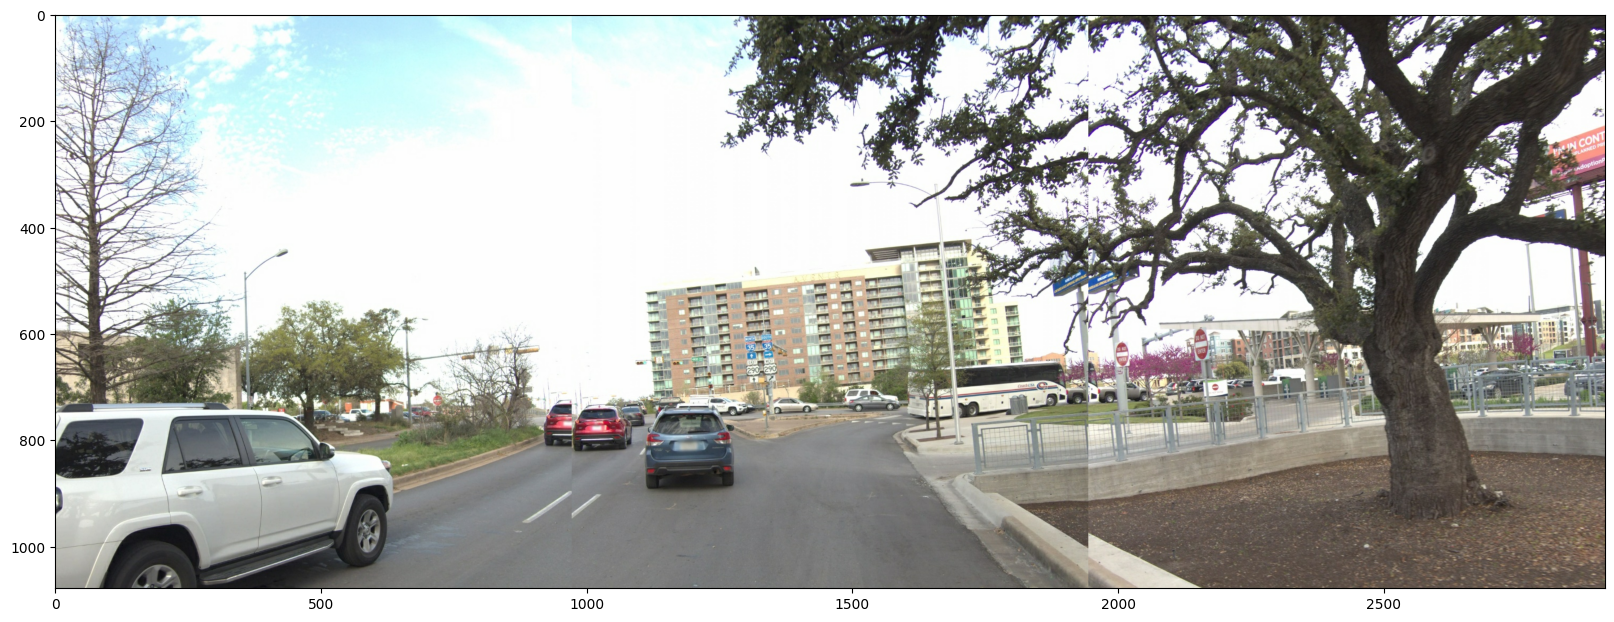

In [44]:
front3_camera_image_list, front3_camera_calibration_list = return_front3_cameras(data)
concatenated_image = np.concatenate(front3_camera_image_list, axis=1)
plt.figure(figsize=(20, 20))
plt.imshow(concatenated_image)

In [65]:
def project_vehicle_to_image(vehicle_pose, calibration, points):
  """Projects from vehicle coordinate system to image with global shutter.

  Arguments:
    vehicle_pose: Vehicle pose transform from vehicle into world coordinate
      system.
    calibration: Camera calibration details (including intrinsics/extrinsics).
    points: Points to project of shape [N, 3] in vehicle coordinate system.

  Returns:
    Array of shape [N, 3], with the latter dimension composed of (u, v, ok).
  """
  # Transform points from vehicle to world coordinate system (can be
  # vectorized).
  pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
  world_points = np.zeros_like(points)
  for i, point in enumerate(points):
    cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
    world_points[i] = (cx, cy, cz)

  # Populate camera image metadata. Velocity and latency stats are filled with
  # zeroes.
  extrinsic = tf.reshape(
      tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32),
      [4, 4])
  intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
  metadata = tf.constant([
      calibration.width,
      calibration.height,
      open_dataset.CameraCalibration.GLOBAL_SHUTTER,
  ],
                         dtype=tf.int32)
  camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

  # Perform projection and return projected image coordinates (u, v, ok).
  return py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata,
                                            camera_image_metadata,
                                            world_points).numpy()

In [46]:
def draw_points_on_image(image, points, size=6, color='r'):
    h, w = image.shape[:2]
    rgb = (255, 0, 0) if color == 'r' else (0, 0, 255)

    for u, v, ok in points:
        if not bool(ok):
            continue
        u_i, v_i = int(round(u)), int(round(v))
        if 0 <= u_i < w and 0 <= v_i < h:
            cv2.circle(image, (u_i, v_i), size, rgb, -1)

    return image


In [47]:
future_waypoints_matrix = np.stack([data.future_states.pos_x, data.future_states.pos_y, data.future_states.pos_z], axis=1)
vehicle_pose = data.frame.images[0].pose

In [48]:
future_waypoints_matrix

array([[ 1.54812622e+00,  3.90625000e-03, -1.16119385e-02],
       [ 3.13591003e+00,  2.45361328e-02, -2.88772583e-02],
       [ 4.75068665e+00,  6.47583008e-02, -4.05044556e-02],
       [ 6.38111877e+00,  1.12670898e-01, -2.77786255e-02],
       [ 8.04534912e+00,  1.66564941e-01, -3.91845703e-02],
       [ 9.73165894e+00,  2.22839355e-01, -4.96444702e-02],
       [ 1.14302826e+01,  2.79968262e-01, -4.81414795e-02],
       [ 1.31341553e+01,  3.31909180e-01, -4.79202271e-02],
       [ 1.48416138e+01,  3.71887207e-01, -6.16760254e-02],
       [ 1.65262451e+01,  3.99963379e-01, -5.94253540e-02],
       [ 1.81819305e+01,  4.08996582e-01, -6.07986450e-02],
       [ 1.97937164e+01,  3.99841309e-01, -6.16378784e-02],
       [ 2.13532562e+01,  3.65112305e-01, -6.61926270e-02],
       [ 2.28561249e+01,  3.01574707e-01, -7.40737915e-02],
       [ 2.42922668e+01,  2.06359863e-01, -9.06906128e-02],
       [ 2.56519165e+01,  8.52050781e-02, -9.40322876e-02],
       [ 2.69366913e+01, -6.18286133e-02

[[-1.0000000e+00 -1.0000000e+00  0.0000000e+00]
 [ 1.3273468e+03  1.9043723e+03  0.0000000e+00]
 [ 1.6450980e+03  1.5969069e+03  0.0000000e+00]
 [ 1.4444636e+03  1.2084236e+03  1.0000000e+00]
 [ 1.4562268e+03  1.0941216e+03  1.0000000e+00]
 [ 1.4583770e+03  1.0208541e+03  1.0000000e+00]
 [ 1.4582100e+03  9.6929340e+02  1.0000000e+00]
 [ 1.4578961e+03  9.3238153e+02  1.0000000e+00]
 [ 1.4583772e+03  9.0611951e+02  1.0000000e+00]
 [ 1.4596506e+03  8.8455951e+02  1.0000000e+00]
 [ 1.4619978e+03  8.6790057e+02  1.0000000e+00]
 [ 1.4651130e+03  8.5454462e+02  1.0000000e+00]
 [ 1.4693134e+03  8.4397125e+02  1.0000000e+00]
 [ 1.4745876e+03  8.3549945e+02  1.0000000e+00]
 [ 1.4808917e+03  8.2903290e+02  1.0000000e+00]
 [ 1.4878060e+03  8.2292694e+02  1.0000000e+00]
 [ 1.4952371e+03  8.1747986e+02  1.0000000e+00]
 [ 1.5028259e+03  8.1221222e+02  1.0000000e+00]
 [ 1.5107268e+03  8.0737549e+02  1.0000000e+00]
 [ 1.5186901e+03  8.0344946e+02  1.0000000e+00]]
#######################################

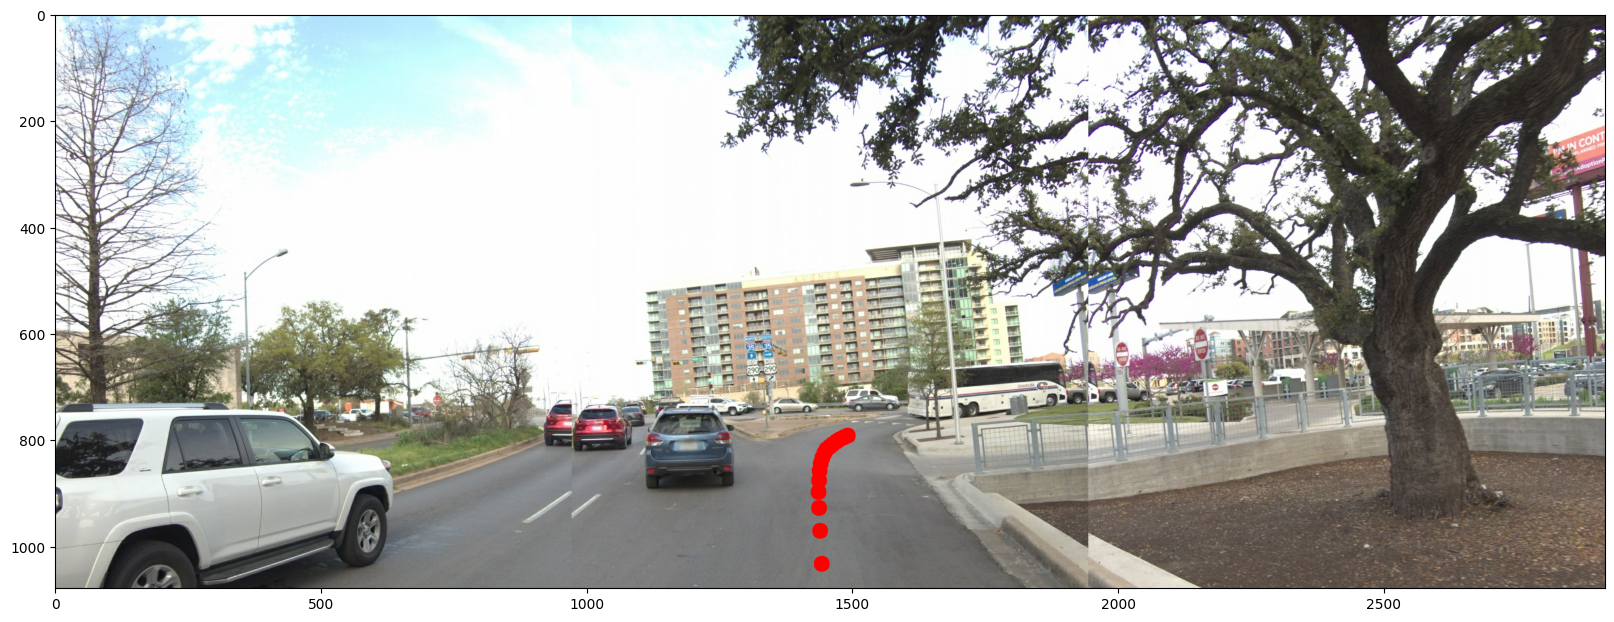

In [67]:
images_with_drawn_points = []
for i in range(len(front3_camera_calibration_list)):
  waypoints_camera_space = project_vehicle_to_image(vehicle_pose, front3_camera_calibration_list[i], future_waypoints_matrix)
  if pred_traj is not None:
    waypoints_generated = project_vehicle_to_image(vehicle_pose, front3_camera_calibration_list[i], pred_traj)
    front3_camera_image_list[i] = draw_points_on_image(front3_camera_image_list[i], waypoints_generated, size=15,color='b')
  print(waypoints_camera_space)
  print('#'.center(80,'#'))
  images_with_drawn_points.append(draw_points_on_image(front3_camera_image_list[i], waypoints_camera_space, size=15))

concatenated_image = np.concatenate(images_with_drawn_points, axis=1)
plt.figure(figsize=(20, 20))
plt.imshow(concatenated_image)

# Submission Generation:
we look at the ```waymo_testing_segments.json``` to retreive a list of sgement ids to look for in our results folder

In [ ]:
import json
with open('waymo_testing_segments.json', 'r') as f:
    segments_json = json.load(f) # Reads and parses JSON from a fil

In [ ]:
predictions = []
processed_id = set()
results_folder = 'qwen_results/openemma/testing/' #please modify
for id in segments_json.keys():
    if id not in processed_id:
        dir = results_folder + id + '/'
        try:
            pred_traj = np.load(dir+'pred_xyz.npy')
        except:
            print(id,' not found')
            continue
        predicted_trajectory = wod_e2ed_submission_pb2.TrajectoryPrediction(pos_x=pred_traj[:20,0],
                                                                            pos_y=pred_traj[:20,1])
        frame_name = id + '-' + segments_json[id][-1]
        frame_trajectory = wod_e2ed_submission_pb2.FrameTrajectoryPredictions(frame_name=frame_name, trajectory=predicted_trajectory)
        # The final prediction should be a list of FrameTrajectoryPredictions.
        predictions.append(frame_trajectory)
        processed_id.add(id)

In [ ]:
# Pack for submission.
num_submission_shards = 1  # Please modify accordingly.
submission_file_base = '/home/hansung/OpenEMMA/submission'  # Please modify accordingly.
if not os.path.exists(submission_file_base):
  os.makedirs(submission_file_base)
sub_file_names = [
    os.path.join(submission_file_base, part)
    for part in [f'mysubmission.binproto-00000-of-00001' for i in range(num_submission_shards)]
]
# As the submission file may be large, we shard them into different chunks.
submissions = []
num_predictions_per_shard =  math.ceil(len(predictions) / num_submission_shards)
for i in range(num_submission_shards):
  start = i * num_predictions_per_shard
  end = (i + 1) * num_predictions_per_shard
  submissions.append(
      wod_e2ed_submission_pb2.E2EDChallengeSubmission(
          predictions=predictions[start:end]))

In [ ]:
import tarfile

for i, shard in enumerate(submissions):
  shard.submission_type  =  wod_e2ed_submission_pb2.E2EDChallengeSubmission.SubmissionType.E2ED_SUBMISSION
  shard.authors[:] = ['Hansung Kim']  # Please modify accordingly.
  shard.affiliation = 'University of California, Berkeley'  # Please modify accordingly.
  shard.account_name = 'hansung@berkeley.edu'  # Please modify accordingly.
  shard.unique_method_name = 'OpenEMMA w/ QwenVLM'  # Please modify accordingly.
  shard.method_link = 'https://github.com/hansungkim98122/OpenEMMA-for-Waymo-E2E'  # Please modify accordingly.
  shard.description = 'Open source implementation of EMMA (Waymo, adopted: https://github.com/taco-group/OpenEMMA) using Qwen-VLM queries'  # Please modify accordingly.
  shard.uses_public_model_pretraining = True # Please modify accordingly.
  shard.public_model_names.extend(['Qwen2-VL-7B-Instruct']) # Please modify accordingly.
  shard.num_model_parameters = "7B" # Please modify accordingly.
  with tf.io.gfile.GFile(sub_file_names[i], 'wb') as fp:
    fp.write(shard.SerializeToString())

with tarfile.open(
  os.path.join(submission_file_base, 'submission.tar.gz'), 'w:gz'
) as tar:
  for output_filename in sub_file_names:
    tar.add(
        os.path.join(submission_file_base, output_filename),
        arcname=output_filename,
    )